# 데이터셋

[Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상

## 구성
#### chest_xray
- train
 - NORMAL 1341개
 - PNEUMONIA 3875개
- val
 - NORMAL 8개
 - PNEUMONIA 8개
- test
 - NORMAL 234개
 - PNEUMONIA 390개

## 폐렴의 구별법
X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰됨

실제로 영상을 보면 희미한 경우가 많아서 실제로 폐렴으로 인한 것인지 아니면 다른 이유 때문인지 파악하기 어려움

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/12_e0QcAmT.png)

>[출처](https://pulsar-kkaturi.tistory.com/entry/X-ray-%EC%98%81%EC%83%81%EC%97%90%EC%84%9C-%ED%8F%90%EB%A0%B4-%EB%B6%84%EB%A5%98)
- 정상적인 흉부 X-RAY(왼쪽): 뼈와 장기를 제외한 비정상적인 음영 영역이 없고 깨끗함
- 세균(박테리아)성 폐렴(Bacterial pnemonia): 마치 침을 '퉤'하고 뱉은 것 처럼 병변이 폐의 중심 또는 아래쪽에서 하얗게 뭉쳐있는 것이 특징
 - 병변이 중심은 하얀부분이 강하게 뭉쳐져 Consolidate의 형태를 보이지만 외곽부로 가면 불규칙하게 반투명한 부분(GGO: Ground-glass opacification)이 퍼져나간다.
- 바이러스성 폐렴(Viral pneumonia): 분무기로 뿌린 것처럼 폐의 영역이 전체적으로 희뿌옇게 보인다.
 - 세균성 폐렴과 반대로 폐 영역 전체적으로 주로 GGO들이 퍼져있으므로 희뿌옇게 보이면 중간중간 작지만 하얗게 뭉쳐진 Consolidate가 보이기도 한다.




# 실험 환경 Set-up

거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

In [1]:
# 패키지 import

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# 앞으로 필요한 변수들을 생성

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 100

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
# 데이터 가져오기

train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
total_len = len(train_filenames) + len(test_filenames) + len(val_filenames)

print(f'train 데이터 개수: {len(train_filenames):>4}개 전체 중 {len(train_filenames)/total_len*100:>4.1f}%')
print(f' test 데이터 개수: {len(test_filenames):>4}개 전체 중 {len(test_filenames)/total_len*100:>4.1f}%')
print(f'  val 데이터 개수: {len(val_filenames):>4}개 전체 중 {len(val_filenames)/total_len*100:>4.1f}%')

train 데이터 개수: 5216개 전체 중 89.1%
 test 데이터 개수:  624개 전체 중 10.7%
  val 데이터 개수:   16개 전체 중  0.3%


val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠습니다.

train과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할하겠습니다.

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(1234)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1094
Pneumonia images count in training set: 3091


결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있습니다. 우리가 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 합니다. 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정입니다. test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없습니다.

In [6]:
# tf.data를 사용하면 tensorflow에서 학습 할 때 효율적인 배치처리가 가능
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# 데이터셋의 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


# 데이터 전처리

원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우 반전 정도의 augmentation만 도입한다고 한다면 다음과 같이 진행될 것입니다.

```python
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
```

현재 이미지에는 라벨 데이터가 따로 없습니다.

파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠습니다.

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높습니다.
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여봅시다.
`decode_img()` 함수와 `process_path()` 함수를 만들겠습니다.

`process_path()` 함수에서 `decode_img()` 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경합니다. `get_label()`을 이용해서 라벨 값을 가져옵니다.

In [7]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 이미지를 알맞은 형식으로 변환
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 형식이 전환된 이미지와 라벨을 반환
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label
    
print('done')

done


In [8]:
# train 데이터셋과 validation 데이터셋 만들기
# num_parallel_calls 파라미터에서 set-up에서 초기화 한 AUTOTUNE을 이용

# 경로를 함수에 넣어서 확인
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

for image, label in train_ds.take(1): # train_ds.take(1): 하나의 데이터만 가져옴
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [9]:
# test 데이터셋 만들기

test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


Tensorflow에서는 `tf.data` 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다.

밑에 있는 `prepare_for_training()` 함수는 학습 데이터를 효율적으로 할 수 있도록 데이터를 변환 시켜줍니다.

- `shuffle()`을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.

- `repeat()`를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 `repeat()`를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
예를 들어, 100개의 데이터를 10번 반복하면 1000개의 데이터가 필요하게 됩니다. `repeat()`를 사용하면 자동으로 데이터를 맞춰줍니다.

- `batch()`를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어집니다.
예를 들어, 100개의 데이터를 10개의 배치로 나누게 되면 각 배치에는 10개의 데이터로 나뉘게 됩니다.

- `prefetch()`를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있습니다.

In [10]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    #ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

print('done')

done


# 데이터 시각화

학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습 코드에 있는 `show_batch()` 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

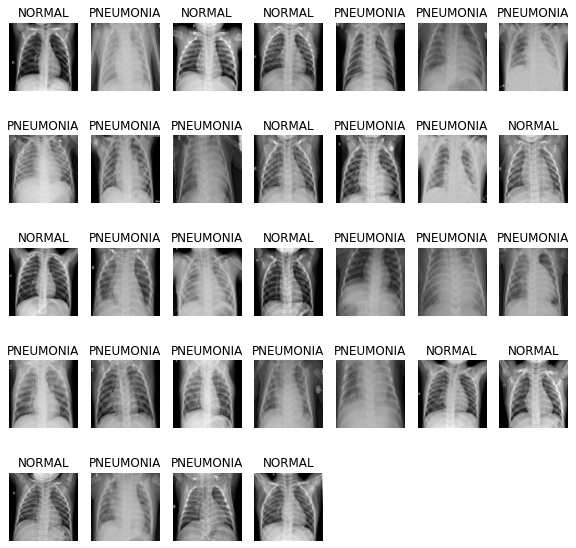

In [11]:
# 추출된 배치를 image와 label로 나누어 확인

# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# CNN 모델링

의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

In [12]:
# Convolution Block
# SeparableConv2D는 연산량을 줄이기 위한 변형 Conv인 것 같다
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense Block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

print('done')

done


In [13]:
# 모델 만들기

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

print('done')

done


# 데이터 imbalnace 처리

실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 `class_weight`를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법입니다. Keras는 `model.fit()`을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다.

아래 코드에서 `weight_for_0`은 'Normal' 이미지에 사용할 weight를, `weight_for_1`은 'Pneumonia' 이미지에 사용할 weight를 세팅합니다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됩니다.


In [14]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.91
Weight for PNEUMONIA: 0.68


# 모델 훈련

loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

loss: binary_cross entropy

optimizer: adam

metrics: accuracy, precision, recall

In [15]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [16]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/100
130/130 [==============================] - 55s 270ms/step - loss: 0.5803 - accuracy: 0.6826 - precision: 0.8877 - recall: 0.6441 - val_loss: 0.5604 - val_accuracy: 0.7559 - val_precision: 0.7559 - val_recall: 1.0000
Epoch 2/100
130/130 [==============================] - 33s 251ms/step - loss: 0.2131 - accuracy: 0.9170 - precision: 0.9767 - recall: 0.9087 - val_loss: 0.7365 - val_accuracy: 0.7559 - val_precision: 0.7559 - val_recall: 1.0000
Epoch 3/100
130/130 [==============================] - 32s 248ms/step - loss: 0.1584 - accuracy: 0.9423 - precision: 0.9800 - recall: 0.9396 - val_loss: 0.8210 - val_accuracy: 0.7568 - val_precision: 0.7568 - val_recall: 1.0000
Epoch 4/100
130/130 [==============================] - 33s 252ms/step - loss: 0.1619 - accuracy: 0.9433 - precision: 0.9809 - recall: 0.9415 - val_loss: 0.9934 - val_accuracy: 0.7578 - val_precision: 0.7578 - val_recall: 1.0000
Epoch 5/100
130/130 [==============================] - 33s 252ms/step - loss: 0.1235 - a

Epoch 37/100
130/130 [==============================] - 33s 253ms/step - loss: 0.0301 - accuracy: 0.9875 - precision: 0.9960 - recall: 0.9872 - val_loss: 0.0746 - val_accuracy: 0.9805 - val_precision: 0.9974 - val_recall: 0.9767
Epoch 38/100
130/130 [==============================] - 33s 255ms/step - loss: 0.0303 - accuracy: 0.9882 - precision: 0.9964 - recall: 0.9879 - val_loss: 0.0714 - val_accuracy: 0.9805 - val_precision: 0.9948 - val_recall: 0.9794
Epoch 39/100
130/130 [==============================] - 33s 254ms/step - loss: 0.0236 - accuracy: 0.9915 - precision: 0.9969 - recall: 0.9917 - val_loss: 0.0554 - val_accuracy: 0.9863 - val_precision: 0.9961 - val_recall: 0.9858
Epoch 40/100
130/130 [==============================] - 33s 252ms/step - loss: 0.0266 - accuracy: 0.9919 - precision: 0.9976 - recall: 0.9914 - val_loss: 0.1062 - val_accuracy: 0.9658 - val_precision: 0.9960 - val_recall: 0.9587
Epoch 41/100
130/130 [==============================] - 33s 253ms/step - loss: 0.027

Epoch 73/100
130/130 [==============================] - 33s 255ms/step - loss: 0.0034 - accuracy: 0.9983 - precision: 1.0000 - recall: 0.9978 - val_loss: 0.0641 - val_accuracy: 0.9844 - val_precision: 0.9847 - val_recall: 0.9949
Epoch 74/100
130/130 [==============================] - 33s 255ms/step - loss: 0.0023 - accuracy: 0.9996 - precision: 0.9999 - recall: 0.9995 - val_loss: 0.0802 - val_accuracy: 0.9795 - val_precision: 0.9960 - val_recall: 0.9767
Epoch 75/100
130/130 [==============================] - 33s 253ms/step - loss: 0.0196 - accuracy: 0.9932 - precision: 0.9980 - recall: 0.9928 - val_loss: 0.0717 - val_accuracy: 0.9795 - val_precision: 0.9935 - val_recall: 0.9794
Epoch 76/100
130/130 [==============================] - 33s 254ms/step - loss: 0.0133 - accuracy: 0.9964 - precision: 0.9994 - recall: 0.9958 - val_loss: 0.1059 - val_accuracy: 0.9668 - val_precision: 0.9921 - val_recall: 0.9642
Epoch 77/100
130/130 [==============================] - 33s 254ms/step - loss: 0.013

# 결과 확인과 시각화

테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

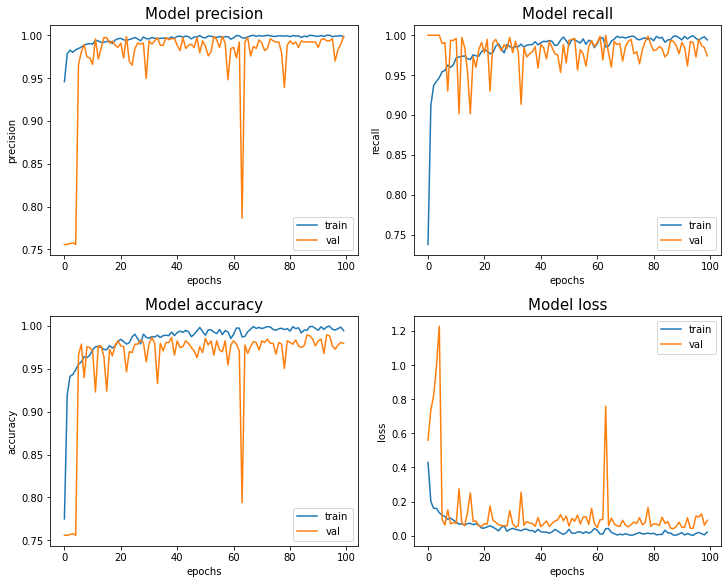

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met), fontsize=15)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [18]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 11s 551ms/step - loss: 1.3846 - accuracy: 0.8029 - precision: 0.7665 - recall: 0.9846
Loss: 1.384578824043274,
Accuracy: 0.8028846383094788,
Precision: 0.7664670944213867,
Recall: 0.9846153855323792


# ImageDataGenerator 를 이용한 데이터 증강 시도

In [19]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from keras.metrics import Precision, Recall

의료 영상이라서 최대한 손을 안 대려고 했으나 정확도가 올라갈까 싶어서 아주 약간의 변형만 가해봄

- rescale: 0에서 1 사이의 값으로 조정
- validation_split: 검증 셋 분리 (주어진 검증셋 16개를 제외하고 train에서 분리)
- rotation_range: 회전각도
- height_shift_range: 위아래로 이동하는 범위의 비율
- zoom_range: 영상 확대 축소 비율
- horizontal_flip: 좌우대칭
- brightness_range: 밝기 조절 비율
- fill_mode: 변형으로 생기는 빈공간 padding 조건




In [20]:
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
BATCH_SIZE = 32
IMG_SIZE = (180, 180) 
IMG_SIZE_CH = (224, 224, 3)
EPOCHS = 100
class_weight = {0: 1.94, 1: 0.67} # 위에서 사용한 가중치를 그대로 적용

# 학습 이미지에 적용한 augmentation 인자를 지정해줍니다.
train_datagen = ImageDataGenerator(rescale = 1./255,          # 픽셀값 스케일 조정
                                   validation_split = 0.2,    # val 폴더는 버리고 train에서 분리
                                   rotation_range = 5,
                                   height_shift_range = 0.05,
                                   zoom_range = 0.05,
                                   horizontal_flip = True,
                                   brightness_range = (0.95,1.05),
                                   fill_mode = 'nearest')    


# 검증 및 테스트 이미지는 augmentation을 적용하지 않습니다.
# 모델 성능을 평가할 때에는 이미지 원본을 사용합니다.
val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

In [21]:
# 이미지를 배치 단위로 불러와 줄 generator입니다.
train_generator = train_datagen.flow_from_directory(
        ROOT_PATH+'/chest_xray/data/train',  # this is the target directory
        target_size=IMG_SIZE,  # 모든 이미지의 크기가 IMG_SIZE로 조정됩니다.
        batch_size=BATCH_SIZE,
        class_mode='binary',  # binary_crossentropy 손실 함수를 사용하므로 binary 형태로 라벨을 불러와야 합니다.
        subset ='training')     # 훈련데이터

val_generator = val_datagen.flow_from_directory(
        ROOT_PATH+'/chest_xray/data/train',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation')    # 검증데이터

test_generator = test_datagen.flow_from_directory(
        ROOT_PATH+'/chest_xray/data/test',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [22]:
# label의 클래스들을 확인

train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

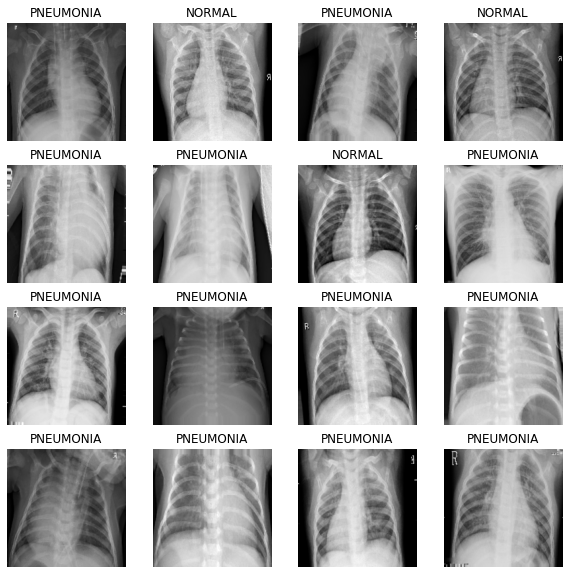

In [23]:
# 이미지 확인
batch = train_generator.next()

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(batch[0][i])
    if batch[1][i]:
        plt.title("PNEUMONIA")
    else:
        plt.title("NORMAL")
    plt.axis("off")
plt.show()

# 전이학습 시도

[참고자료](https://www.koreascience.or.kr/article/CFKO201826259815416.pdf)

VGG16, IncenptionV3, DenseNet201, ResNet152, MobileNetV2 다섯가지의 선행학습 모델을 시도해 보았고 그 중 하나인 DenseNet201의 결과만 다시 출력해보았다

[시도해본 흔적들](https://github.com/ysmNew/Aiffel/blob/main/Ex11/Ex11_trycode.ipynb)

## VGG16
![](https://media.vlpt.us/images/yvelog/post/80a763d5-9717-419e-b213-4ed7ab4ab8bc/image.png)

## IncenptionV3
![](https://media.vlpt.us/images/yvelog/post/0c99104b-325e-420f-8802-05b634427ed0/image.png)

## ResNet152
![](https://media.vlpt.us/images/yvelog/post/3105b763-a878-4127-924b-72999fc3d127/image.png)

## MobileNetV3
![](https://media.vlpt.us/images/yvelog/post/f97064be-56c9-4051-9e2e-05f57b351582/image.png)

In [24]:
from keras import applications

DenseNet201_MODEL = applications.DenseNet201(input_shape = IMG_SIZE_CH, 
                           include_top=False, 
                           weights='imagenet') 
# 사전훈련된 가중치를 이용해 기본 모델을 인스턴스화

DenseNet201_MODEL.trainable=False                   # 기본 모델을 동결

74842112/74836368 [==============================] - 1s 0us/step


In [25]:
from keras.layers import GlobalAveragePooling2D

model = Sequential()
model.add(DenseNet201_MODEL)
model.add(GlobalAveragePooling2D())  # flatten대신 globalaveragepooling
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.7))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', 
                       Precision(name='precision'),
                       Recall(name='recall')])

In [26]:
history = model.fit(
        train_generator,
        steps_per_epoch=4173 // BATCH_SIZE, # 트레인 데이터 총 4173개
        validation_data=val_generator,
        epochs=EPOCHS,
        class_weight=class_weight)

Epoch 1/100
130/130 [==============================] - 351s 2s/step - loss: 0.5611 - accuracy: 0.7454 - precision: 0.8809 - recall: 0.7562 - val_loss: 0.2392 - val_accuracy: 0.8945 - val_precision: 0.9897 - val_recall: 0.8671
Epoch 2/100
130/130 [==============================] - 88s 673ms/step - loss: 0.2560 - accuracy: 0.8967 - precision: 0.9616 - recall: 0.8964 - val_loss: 0.1690 - val_accuracy: 0.9319 - val_precision: 0.9848 - val_recall: 0.9226
Epoch 3/100
130/130 [==============================] - 86s 658ms/step - loss: 0.2403 - accuracy: 0.9069 - precision: 0.9685 - recall: 0.9032 - val_loss: 0.1497 - val_accuracy: 0.9367 - val_precision: 0.9746 - val_recall: 0.9394
Epoch 4/100
130/130 [==============================] - 82s 633ms/step - loss: 0.2193 - accuracy: 0.9166 - precision: 0.9713 - recall: 0.9158 - val_loss: 0.1272 - val_accuracy: 0.9492 - val_precision: 0.9763 - val_recall: 0.9548
Epoch 5/100
130/130 [==============================] - 83s 640ms/step - loss: 0.2254 - acc

Epoch 37/100
130/130 [==============================] - 82s 626ms/step - loss: 0.1192 - accuracy: 0.9553 - precision: 0.9889 - recall: 0.9507 - val_loss: 0.1080 - val_accuracy: 0.9463 - val_precision: 0.9905 - val_recall: 0.9368
Epoch 38/100
130/130 [==============================] - 81s 624ms/step - loss: 0.1094 - accuracy: 0.9570 - precision: 0.9874 - recall: 0.9546 - val_loss: 0.1097 - val_accuracy: 0.9425 - val_precision: 0.9917 - val_recall: 0.9303
Epoch 39/100
130/130 [==============================] - 83s 636ms/step - loss: 0.1226 - accuracy: 0.9467 - precision: 0.9857 - recall: 0.9431 - val_loss: 0.1261 - val_accuracy: 0.9386 - val_precision: 0.9917 - val_recall: 0.9252
Epoch 40/100
130/130 [==============================] - 82s 626ms/step - loss: 0.1147 - accuracy: 0.9543 - precision: 0.9887 - recall: 0.9500 - val_loss: 0.1329 - val_accuracy: 0.9329 - val_precision: 0.9930 - val_recall: 0.9161
Epoch 41/100
130/130 [==============================] - 81s 625ms/step - loss: 0.126

Epoch 73/100
130/130 [==============================] - 82s 626ms/step - loss: 0.0993 - accuracy: 0.9573 - precision: 0.9901 - recall: 0.9524 - val_loss: 0.1143 - val_accuracy: 0.9473 - val_precision: 0.9932 - val_recall: 0.9355
Epoch 74/100
130/130 [==============================] - 81s 625ms/step - loss: 0.0965 - accuracy: 0.9626 - precision: 0.9916 - recall: 0.9582 - val_loss: 0.1303 - val_accuracy: 0.9338 - val_precision: 0.9930 - val_recall: 0.9174
Epoch 75/100
130/130 [==============================] - 83s 637ms/step - loss: 0.1031 - accuracy: 0.9581 - precision: 0.9862 - recall: 0.9575 - val_loss: 0.1017 - val_accuracy: 0.9540 - val_precision: 0.9919 - val_recall: 0.9458
Epoch 76/100
130/130 [==============================] - 82s 627ms/step - loss: 0.1033 - accuracy: 0.9617 - precision: 0.9889 - recall: 0.9595 - val_loss: 0.1592 - val_accuracy: 0.9233 - val_precision: 0.9957 - val_recall: 0.9006
Epoch 77/100
130/130 [==============================] - 82s 631ms/step - loss: 0.099

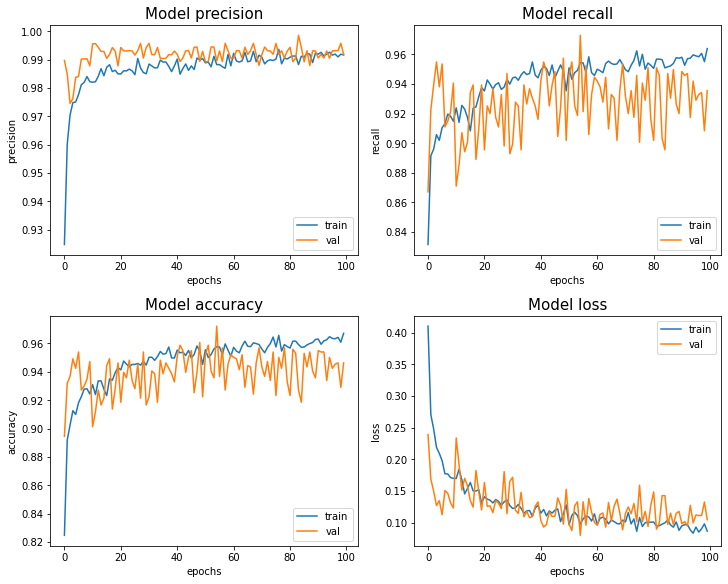

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met), fontsize=15)
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 78s 4s/step - loss: 0.5281 - accuracy: 0.8910 - precision: 0.8659 - recall: 0.9769
Loss: 0.5281419157981873,
Accuracy: 0.8910256624221802,
Precision: 0.8659090995788574,
Recall: 0.9769230484962463


# 회고

사실 의료영상이라서 데이터에 최대한 손을 안 대려고 했는데 정확도가 80% 넘기도 힘들어서....

실제로 분석하는 건 아니니 데이터 증강 연습할 겸 손을 좀 댔다.

처음에는 GAN으로 해보고 싶었는데 뭔가 시작부터 진행이 안 돼서 GG...

그 다음에 이미지 데이터 증강에 사용되는 ImageDataGanerater를 이용해서 아주 약간만 변형을 가해보았다.

그런데 아주 살짝 변하는거라면 증강의 의미가 없지 않나 싶기도 하고... 

데이터의 수가 많지 않은 케이스이므로 전이학습을 시도해 보았는데

모델에 대한 이해가 없기 때문에 뭐가 제일 좋을지 몰라서 일단 눈에 보이는대로 돌려보았다.

몇번씩 시도해보아도 역시나 뭐가 더 나은건지 모르겠고..

val의 값이 미친듯이 날뛰는걸 잡기 위해서 배치사이즈도 늘리고, 에폭도 늘리고 해봤는데

배치사이즈는 일정 이상 높이니까 오류가 떠서 생각만큼 조절을 못했고 에폭은 늘릴수록 시간이 엄청 걸려서....

애초에 전이학습이 학습된 가중치가 의료영상과는 많은 차이가 있다보니 제대로 학습이 안 되는 것 같다

fine tuning이나 아니면 선행모델의 일부를 더 가져와서 학습시키거나 해 보면 조금 더 나은 결과가 나올지...ㅠㅠ

정확도는 올랐는데 recall이 떨어진 현상을 어떻게든 잡아내고 싶었는데 못해서 아쉽다.